In [1]:
import sys
sys.path.append('..')
import nbimport 
nbimport.initialize()

In [2]:
from Stat_17 import *
css_styling()

# Template fitting

# Skabelontilpasning

## Purpose 

- To familiarize yourself with the concept of _template fitting_ 
- To implement versatile and generic functionality for template fitting 

## Formål

- At sætte dig ind i begrebet _skabelontilpasning_
- At implementere alsidig og generisk funktionalitet til skabelontilpasning

## Introduction 

The practice of template fitting is very common in experimental high energy particle physics (HEP), and finds applications many other places.   The concept of template fitting is relatively straight forward: 

> Instead of fitting analytical expression to observations, we fit pre-determined empirical 
> distributions to the observations. 

The pre-determined distributions are the _templates_.  These could be generated in many different ways but a few common cases are 

- Background distributions from known processes. 
- Signal distributions from hypothetical processes.

Template fitting then consists of modifying the overall scale, shape, or relative "strengths" of templates possibly added together.   Thus, the free parameters of the fits are typically 

- Overall scaling factor of a template.
- Relative variation of a template within fiducial bounds (both overall and modifying shape). 

Templates can have many forms but are typically expressed as binned data - i.e., histograms.  Typically we will perform the fit using an _extended maximum likelihood estimate_, since least-squares fitting is less flexible with respect to its assumptions. 

## Introduktion

Praksisen med skabelontilpasning er meget almindelig i eksperimentel højenergipartikelfysik (HEP) og finder anvendelser mange andre steder. Konceptet for skabelontilpasning er relativt ligetil:

> I stedet for at tilpasse analytisk udtryk til observationer, tilpasser vi forudbestemte, empiriske
> fordelinger til observationer.

De forudbestemte distributioner er _skabeloner_. Disse kan genereres på mange forskellige måder, men nogle få almindelige tilfælde er

- Baggrundsfordelinger fra kendte processer.
- Signalfordelinger fra hypotetiske processer.

Skabelontilpasning består derefter af at ændre den samlede skala, form eller relative "styrker" af skabeloner, der er lagt sammen. Således er de frie parametre for tilpasninger typisk

- Samlet skaleringsfaktor for en skabelon.
- Relativ variation af en skabelon inden for fiduciale grænser (både samlet og modificerende af fordelingerne).

Skabeloner kan have mange former, men udtrykkes typisk som data i bøtter - dvs. histogrammer. Typisk vil vi udføre tilpasningen ved hjælp af et _udvidet maksimalt sandsynlighedsestimat_, da tilpasning med mindste-kvadrat er mindre fleksibel med hensyn til dens antagelser.

## A simple example

## Et simpelt eksempel

Suppose we have a data sample drawn from a normal distribution.   Then suppose we have a template, also from a normal distribution.  What we want to do, is to find the overall scaling parameter such that our template fits the data sample as best possible.   Let us start by generating the two samples and put them into histograms. 

Antag, at vi har en dataprøve trukket fra en normal distribution. Antag, at vi har en skabelon, også fra en normal distribution. Vi vil finde den overordnede skaleringsparameter, så vores skabelon passer bedst muligt til prøven. Lad os starte med at generere de to prøver og sætte dem i histogrammer.

Example of data and template.

Eksempel på data og skabelon.

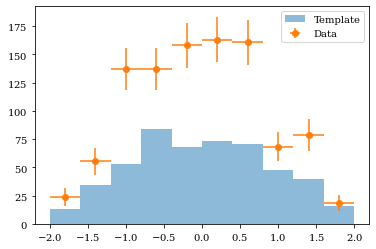

In [3]:
from numpy.random import seed, normal 
from numpy import linspace 
from matplotlib.pyplot import legend 

seed(12345)

templ_x = normal(size=200)
data_x  = normal(size=400)
bins    = linspace(-2,2,11)
templ_h = histogram(templ_x,bins)
data_h  = histogram(data_x, bins)

plot_hist(*templ_h,color='C0',label='Template',as_bar=True,ecolor='none',alpha=.5)
plot_hist(*data_h, color='C1',label='Data',fmt='o')
legend();

Let us do an extended binned maximum likelihood estimate with Poisson assumption of bin content, of the scale on our template to best fit the data.  To that end, we need to define a PDF-like function we can pass to our EB-MLE routine (`mle_fit`).  

In this simple example, we will use the _bin number_ as the independent variable to keep our function simple.  The only free parameter of the function is the overall scale factor. 

Lad os foretage et udvidet overslag over maksimal sandsynlighed med Poisson antagelse af bøtte-indholdet, af skalaen på vores skabelon, så den bedst passer til data. Dertil er vi nødt til at definere en PDF-lignende funktion, som vi kan videregive til vores EB-MLE-rutine (`mle_fit`).

I dette enkle eksempel bruger vi _bøtte-nummer_ som den uafhængige variabel for at holde vores funktion enkel. Den eneste frie parameter for funktionen er den samlede skalafaktor.

In [4]:
def f(binno,scale):
    return scale * templ_h[0][binno.astype(int)]

We define the range of bin numbers as our independent variable and then perform a EB-MLE fit.

Vi definerer følgen af bøtte-numre som vores uafhængige variabel og udfører derefter en EB-MLE tilpasning.

In [5]:
binno = linspace(-.5, len(bins)-.5, len(bins))
p, cov = mle_fit(f,(binno,data_h[0]),(1,3),extended=True,poisson=True)

We can draw our fitted template with the data and original template 

Vi kan tegne vores tilpasset skabelon sammen med data og den originale skabelon

Template fitted to data. 

Skabelon tilpasset data.

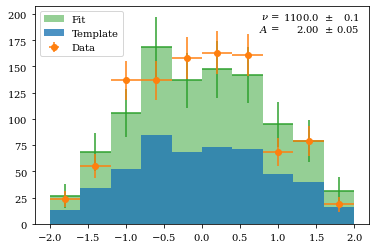

In [6]:
ret_h = p[1]*templ_h[0],*templ_h[1:3],p[1]*templ_h[3]
plot_hist(*ret_h,  color='C2',label='Fit',     as_bar=True,ecolor='C2',alpha=.5)
plot_hist(*templ_h,color='C0',label='Template',as_bar=True,ecolor='none',alpha=.8)
plot_hist(*data_h, color='C1',label='Data',fmt='o')
plot_fit_table(p,cov,parameters=[r'\nu','A'])
legend(loc='upper left');

We see that the fit correctly finds a factor of 2, but the overall normalization is not correct as we used the bin index as the independent variable.  However, clearly by multiplying by the bin width we get roughly the right overall normalization. 

Vi ser, at tilpasningen korrekt finder en faktor 2, men den samlede normalisering er ikke korrekt. Det er på grund af vi brugte bøtte-indekset som den uafhængige variabel, hvilket givet en større bøtte-brede (1) en hvad er tilfældet ($0.4$). Imidlertid klart ved at multiplicere med skraldespændingsbredden får vi nogenlunde den rigtige samlede normalisering.

While the using the bin index is relatively efficient, it is not particularly effective.  So we will make a small function to turn a histogram into a PDF-like function.  

Selvom brug af bøtte-indekset er relativt effektivt, er det ikke særlig effektivt. Så vi laver en lille funktion til at omdanne et histogram til en PDF-lignende funktion.

## PDF from a histogram 

This function takes data in the form of correlated pairs $x_i,y_i$ and returns a function that will interpolate between the measurements.  The interpolation kind depends on the `kind` keyword (see also `scipy.interpolate.interp1d`.  The value `kind=nearest` will, like in our example above, return the given $y_i$ value closest to the argument. 

## PDF fra et histogram

Denne funktion tager data i form af korrelerede par $x_i,y_i$ og returnerer en funktion, der interpolerer mellem målingerne. Interpolationstypen afhænger af nøgleordet `kind` (se også `scipy.interpolate.interp1d`. Værdien `kind=nearest` vil, som i vores eksempel ovenfor, returnere den givne $y_i$-værdi tættest på argumentet.

In [7]:
def histo_pdf(x,y,kind='linear',extra=True,logpdf=False,**kwargs):
    from scipy.interpolate import interp1d
    from numpy import log, where, errstate, inf
    
    with errstate(all='ignore'):
        yy = where(y > 0, log(y), -inf) if logpdf else y
    inter = interp1d(x,yy,kind=kind,bounds_error=False,assume_sorted=True,
                     fill_value='extrapolate' if extra else (0,0))
    
    def f(xx,**kwargs): # Keyword arguments are ignored
        return inter(xx)
    
    return f

### Test

Let us test this.  We will use our template histogram from above, and we will plot the different interpolation kinds (offset for illustration purposes)

### Test

Lad os teste dette. Vi bruger vores skabelonhistogram fra ovenover, og vi tegner de forskellige interpolationstyper (med forskuding til illustration af de forskellige typer).

Different kinds of interpolation possible with `hist_pdf`.  Note, the various curves have been offset. 

Forskellige former for interpolering muligt med `hist_pdf`. Bemærk, de forskellige kurver er blevet forskut

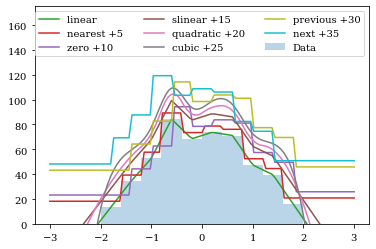

In [8]:
from matplotlib.pyplot import plot, gca

plot_hist(*templ_h,label='Data',as_bar=True,alpha=.3,ecolor='none')
gca()._get_lines.get_next_color()

xev = linspace(-3,3,101)

for i,kind in enumerate(['linear', 'nearest', 'zero', 'slinear', 'quadratic', 
                         'cubic', 'previous', 'next']):
    pdf = histo_pdf(templ_h[1],templ_h[0],kind=kind)
    plot(xev,pdf(xev)+5*i,'-',label=f'{kind} {f"+{5*i}" if i > 0 else ""}')
    
gca().set_ylim(0,175)
legend(ncol=3);

The most _un_-controversial kinds are `linear` and `nearest`.  Of these, the latter corresponds to evaluating the histogram more or less directly.   `linear` is simple and the assumptions are relatively straight forward.   A little more controversial are the kinds `slinear`, `quadratic`, and `cubic`.  These represents smooth interpolations and are appropriate if we believe the data to be smoother than the given sample.   The kinds `zero`, `previous`, and `next` generally do not correspond to our data. 

Note, if we want to the PDF to go to 0 for `nearest`, `next`, and `previous`, we must pass the keyword `extra=False` (for no extrapolation).

De mest _u_kontroversielle slags er `linear` og `nearest`. Af disse svarer sidstnævnte til evaluering af histogrammet mere eller mindre direkte. `linear` er enkel, og antagelserne er relativt ligetil. Lidt mere kontroversielt er slags `slinear`, `quadratic` og `cubic`. Disse repræsenterer glatte interpolationer og er passende, hvis vi mener, at dataene er glattere end den givne prøve. Typerne `zero`, `previous` og `next` svarer generelt ikke til vores data.

Bemærk, hvis vi ønsker at PDF'en skal gå til 0 for `nearest`, `next` og `previous`, skal vi videregive nøgleordet `extra=False` (for ingen ekstrapolation).

Interpolation types `nearest`, `previous`, and `next` with no extrapolation. 

Interpolationstyper `nearest`, `previous` og `next` uden ekstrapolering.

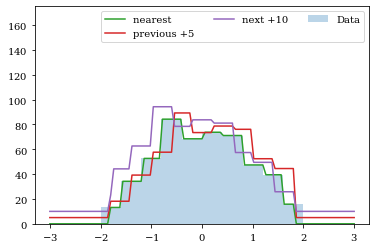

In [9]:
plot_hist(*templ_h,label='Data',as_bar=True,alpha=.3,ecolor='none')
gca()._get_lines.get_next_color()

for i,kind in enumerate(['nearest', 'previous', 'next']):
    pdf = histo_pdf(templ_h[1],templ_h[0],kind=kind, extra=False)
    plot(xev,pdf(xev)+5*i,'-',label=f'{kind} {f"+{5*i}" if i > 0 else ""}')
    
gca().set_ylim(0,175)
legend(ncol=3);

## Decorators

In the example above we introduced a _scale_ on our template histogram that we fitted to the data.  Here, we will implement a [_decorator_](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators) which adds a scale parameter to a PDF (or possibly logarithmic PDF).  In the following, we will use decorators a bit, so we offer a few words on those here. 

A decorator modifies the behaviour of a function (or class method) by wrapping the function in another function.  The wrapper function can thus do pre- and post-processing, change arguments, and so forth.  Let us illustrate this by a simple decorator.  

First, a decorator is a function like any other function, but must accept a single _callable_ (function or method) as it's only argument.   Below, we make a decorator that prints out `Hello` and `Goodbye` before and after, respectively, the wrapped function call. 

## Dekoratører

I eksemplet ovenfor introducerede vi en _skala_ på vores skabelonhistogram, som vi tilpassede data. Her implementerer vi en _dekoratør_ (engl.  [_decorator_](https://en.wikipedia.org/wiki/Python_syntax_and_semantics#Decorators)), som tilføjer en skalaparameter til en PDF (eller muligvis logaritmisk PDF). I det følgende vil vi bruge dekoratører lidt, så vi givet et par ord med på vejen om _decorators_ her.

En dekoratør ændrer opførslen af en funktion (eller klassemetode) ved at indpakke funktionen i en anden funktion. Indpakningsfunktionen kan således udføre før- og efterbehandling, ændre argumenter osv.. Lad os illustrere dette med en simpel dekoratør.

Først og fremmest er en dekoratør en funktion som enhver anden funktion, men skal acceptere en enkel _callable_  (funktion eller metode), som det eneste argument. Nedenfor laver vi en dekoratør, der udskriver `Hello` og `Goodbye` henholdsvis før og efter det indpakket funktionskald.

In [10]:
def before_after(f):
    from functools import wraps
    
    @wraps(f)
    def wrapper(*args):
        print('Hello')
        r = f(*args)
        print('Goodbye')
        return r
        
    return wrapper 

Note, the function `before_after` returns a _function_ (`wrapper`).  That function, when called, prints out our friendly greeting, calls the wrapped function with any arguments passed, and ends with a sign-off.  Any return value of the wrapped function is forwarded back to the caller of the wrapper.  Let us decorate a few functions with this decorator 

Bemærk, funktionen `before_After` returnerer en _funktion_ (`wrapper`). Denne funktion udskriver, når den kaldes, vores venlige hilsen, kalder den indpakkede funktion med eventuelle argumenter, og afslutter med en afmelding. Enhver returneringsværdi af den indpakkede funktion videresendes tilbage til kalderene af indpakningen. Lad os dekorere et par funktioner med denne dekoratør

In [11]:
@before_after
def the_question():
    print('Life, the universe, and everything')
    
@before_after
def the_answer(a):
    if a == 42:
        print(f'Correct: {a}')
    else:
        print(f'Read a book!')
    return a == 42 

The two functions above have both been decorated by `before_after` (the `@before_after` above the `def` of each function).  Let us call them

De to funktioner ovenfor er begge dekoreret af `before_after` (`@before_after` over `def` for hver funktion). Lad os kalde dem

In [12]:
the_question()
print(the_answer(42))

Hello
Life, the universe, and everything
Goodbye
Hello
Correct: 42
Goodbye
True


Let us look a little at the output.  

First, the result of calling `the_question()`:

- The first line `Hello` comes from the wrapper 
- The second line `Life, the universe, and everything` is from the decorated `the_question` 
- The third line `Goodbye` is again from the wrapper. 

The next 3 lines are from calling `the_answer(42)`.  Note, the final line `True` comes printing the return value of the decorated `the_answer` function. 

Lad os se lidt på output.

For det første resultatet af at kalde `the_question()`:

- Den første linje `Hello` kommer fra indpakningen
- Den anden linje `Life, the universe and everything` er fra det dekorerede `the_question`
- Den tredje linje `Goodbye` kommer igen fra indpakningen.

De næste 3 linjer kommer fra at kalde `the_answer(42)`. Bemærk, den sidste linje `True` kommer med udskrivning af returneringsværdien for den dekorerede `the_answer`-funktion.

The definition of `the_question` roughly corresponds to 

Definitionen af `the_question` svarer omtrent til

In [13]:
def _temp():
    print('Life, the universe, and everything')
    
the_question2 = before_after(_temp)
the_question2()

Hello
Life, the universe, and everything
Goodbye


Decorators themselves can have arguments to parameterize the behaviour.   This, however, requires two levels of wrapping - the first will wrap the `@` line, while the second wraps the defined function.  A short example 

Dekoratører kan selv tage argumenter for at parameterisere opførslen. Dette kræver dog to niveauer af indpakning - det første vil ombryde indpakke linjen `@`, mens den anden indpakker den definerede funktion. Et kort eksempel

In [14]:
def decorator_with_argument(x):
    
    def wrap(f):  # f is function to wrap 
        from functools import wraps 
        
        @wraps(f) 
        def wrapper(y):
            return f(y-x)
        
        return wrapper 
    
    return wrap
        
@decorator_with_argument(10)
def minus10(y): 
    return y

@decorator_with_argument(20)
def minus20(y): 
    return y

print(minus10(20),minus20(100))

10 80


The above definition of `minus10` is rougly equivalent to 

Ovenstående definition af `minus10` svarer groft til

In [15]:
def _temp(y):
    return y 

minus10 = decorator_with_argument(10)(_temp)
print(minus10(20))

10


The examples above are clearly a bit contrived, but we will soon see more substantial examples of the power of decorators.  

Eksemplerne ovenfor er tydeligvis konstruerede, men vi vil snart se mere omfattende eksempler på dekoratørernes magt.

## Scale of PDF 

With the basic principles of decorators in order, we can define decorator that adds a scaling factor onto a PDF.  If the _undecorated_ function evaluates 

$$f(x;\hat\theta) = \ldots\quad,$$ 

then the _decorated_ function evaluates 

$$f_w(x;a,\hat\theta) = a\cdot f(x;\hat\theta)\quad.$$

If the _undecorated_ function corresponds to the logarithm of a PDF ($g=\log f$), we should pass the argument `logpdf=True` to the decorator. If that is the case, then the decorated function will evaluate 

$$g_w(x;a,\hat\theta) = \log\left(a\cdot f(x;\hat\theta)\right) = \log(a) + g(x;\hat\theta)\quad.$$

Note, the decorator _adds an additional argument to the front of the argument list_. 

## Skalaring af PDF

Med de grundlæggende principper for dekoratører i orden kan vi definere dekoratører, der tilføjer en skaleringsfaktor på en PDF. Hvis funktionen _udekoreret_ evaluerer

$$f(x;\hat\theta) = \ldots\quad,$$

vil den _dekoreret_ funktion evaluerer 

$$f_w(a;n,\hat\theta) = a\cdot f(x;\hat\theta)\quad.$$

Hvis den _udekoreret_ funktion svarer til logaritmen af en PDF ($g=\log f$), skal vi give argumentet `logpdf=True` til dekoratøren. Hvis dette er tilfældet evaluerer den dekoreret funktion

$$g_w(x;a,\hat\theta) = \log\left(a\cdot f(x;\hat\theta)\right) = \log(a) + g(x;\hat\theta)\quad.$$

Bemærk, dekoratøren _tilføjer et yderligere argument forest til argumentlisten_.

In [16]:
def scale_pdf(logpdf=False):
    from numpy import log, add, multiply, inf
    from functools import wraps
    
    op = add if logpdf else multiply 
    lf = (lambda a : log(a) if a > 0 else -inf) if logpdf else (lambda a : a)
    
    def wrap(f):
        @wraps(f)
        def wrapped(x,a,*args,**kwargs):
            return op(lf(a), f(x,*args,**kwargs))
            
        return wrapped
    return wrap 

### Test

We can apply our decorator `scale_pdf` and `histo_pdf` to our simple template fit example above.  First, we get a PDF from our histogram 

Vi kan anvende vores dekoratør `scale_pdf` og `histo_pdf` på vores enkle skabelontilpasnings-eksempel ovenover. Først laver vi en PDF fra vores histogram

In [17]:
_pdf = histo_pdf(templ_h[1],templ_h[0],kind='nearest')

Then, we wrap that in a function decorated by `scale_pdf` 

Derefter indpakker vi den i en funktion dekoreret med `scale_pdf`

In [18]:
@scale_pdf(logpdf=False)
def pdf(x):
    return _pdf(x)

We can now perform our template fit using this PDF. 

Vi kan nu udføre vores skabelontilpasning ved hjælp af denne PDF.

Example of template fit with a scaled PDF.

Eksempel på skabelon tilpasning med en skaleret PDF.

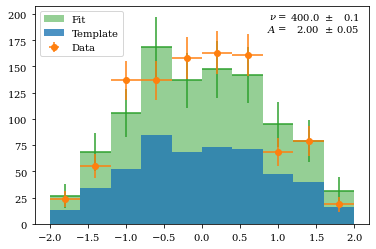

In [19]:
p, co = mle_fit(pdf,(bins,data_h[0]),(1,3),extended=True,poisson=True)

ret_h = p[1]*templ_h[0],*templ_h[1:3],p[1]*templ_h[3]

plot_hist(*ret_h,  color='C2',label='Fit',     as_bar=True,ecolor='C2',alpha=.5)
plot_hist(*templ_h,color='C0',label='Template',as_bar=True,ecolor='none',alpha=.8)
plot_hist(*data_h, color='C1',label='Data',fmt='o')
plot_fit_table(p,cov,parameters=[r'\nu','A'])
legend(loc='upper left');

We see that we find the same scaling as above, but since we now use the proper bin values (and spacing) we find a good estimate of the overall scaling. 

Vi ser, at vi finder den samme skalering som ovenfor, men da vi nu bruger de rette bøtte-værdier (og breder) finder vi et godt skøn over den samlede skalering.

We can also generate a logarithmic PDF from the histogram and scale that.  In that case, we must pass `logpdf=True` to `scale_pdf`, `histo_pdf`, and `mle_fit`.  Let us do that below. 

Vi kan også generere en logaritmisk PDF fra histogrammet og skalere den. I så fald skal vi videregive `logpdf=True` til `scala_pdf`, `histo_pdf` og `mle_fit`. Lad os gøre det nedenfor.

Scaled logaritmic template fitted to data. 

Skaleret logaritmisk skabelon tilpasset data.

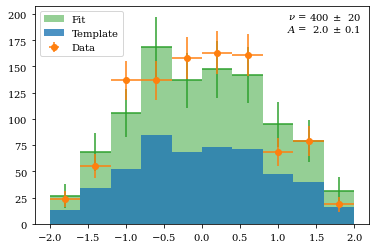

In [20]:
@scale_pdf(logpdf=True)
def lpdf(x,_lpdf=histo_pdf(templ_h[1],templ_h[0],kind='nearest',logpdf=True)):
    return _lpdf(x)

p, cov = mle_fit(lpdf,(bins,data_h[0]),(1,1),extended=True, 
                 poisson=True,logpdf=True)

ret_h = p[1]*templ_h[0],*templ_h[1:3],p[1]*templ_h[3]

plot_hist(*ret_h,  color='C2',label='Fit',     as_bar=True,ecolor='C2',alpha=.5)
plot_hist(*templ_h,color='C0',label='Template',as_bar=True,ecolor='none',alpha=.8)
plot_hist(*data_h, color='C1',label='Data',fmt='o')
plot_fit_table(p,cov,parameters=[r'\nu','A'])
legend(loc='upper left');

### Example: Peak over background 

Suppose we have _two_ templates - an exponential background and a normal signal.  _A priori_ we do not know the relative strengths of each of these, so we want to leave that free in our fit.   First, let us define our templates 

### Eksempel: Top over baggrund

Antag, at vi har _to_ skabeloner - en eksponentiel baggrund og et normalfordelt signal. _A priori_ vi kender ikke de relative styrker af hver af disse, så vi vil lade dem være frie i vores tilpasning. Lad os først definere vores skabeloner

Peak and background templates.

Top- og baggrundsskabeloner.

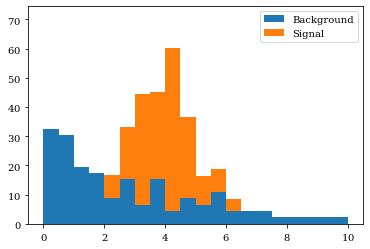

In [21]:
from numpy.random import exponential
seed(42)

backg_x  = exponential(4,size=100)
signal_x = normal     (4,size=100)

bins     = linspace(0,10,21)
backg_h  = histogram(backg_x, bins)
signal_h = histogram(signal_x,bins)

plot_hist(*backg_h,            as_bar=True,ecolor='none',label='Background')
plot_hist(*signal_h,backg_h[0],as_bar=True,ecolor='none',label='Signal')
legend();

Above, we have made our signal and background templates of equal size.  Let us generate the observed distribution, where the signal is half the size of the background 

Ovenfor har vi lavet vores signal- og baggrundsskabeloner af samme størrelse. Lad os generere den observerede distribution, hvor signalet er halvt så stort som baggrunden

Peak and background templates, and data,

Top- og baggrundsskabeloner og data,

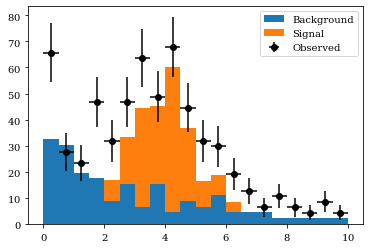

In [22]:
from numpy import concatenate

data_x = concatenate((exponential(4,size=200),
                      normal     (4,size=100)))
data_h = histogram(data_x,bins)

plot_hist(*backg_h,            as_bar=True,ecolor='none',label='Background')
plot_hist(*signal_h,backg_h[0],as_bar=True,ecolor='none',label='Signal')
plot_hist(*data_h,             fmt='o',     color='k',   label='Observed')
legend();

We now want to adjust the strengths of the two templates so as to best fit the observations.   We do so by defining two scaled PDFs from our histograms and then a single PDF to add these together. 

Vi ønsker nu at justere styrken af de to skabeloner, så de passer bedst til observationerne. Det gør vi ved at definere to skalerede PDF'er fra vores histogrammer og derefter en enkelt PDF for at lægge disse sammen.

In [23]:
@scale_pdf()
def backg_f(x,h=histo_pdf(backg_h[1], backg_h[0], kind='nearest')):
    return h(x)

@scale_pdf()
def signal_f(x,h=histo_pdf(signal_h[1],signal_h[0],kind='nearest')):
    return h(x)

def pdf(x,backg_a,signal_a):
    return backg_f(x,backg_a) + signal_f(x,signal_a)

With the PDF defined, we can perform our BE-MLE fit to the data. 

Med den definerede PDF kan vi udføre vores BE-MLE tilpasning til data.

In [24]:
p, cov = mle_fit(pdf,(bins,data_h[0]),(1,1,1),
                 extended=True,poisson=True,tol=1e-6)

We plot the templates, data, and fitted PDF. 

Vi tegner skabelonerne, data og den tilpasset PDF.

Peak and background templates, data, and fit result. 

Top- og baggrundsskabeloner, data og pasningsresultat.

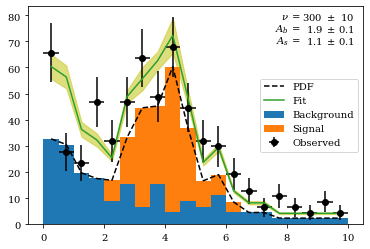

In [25]:
x   = (bins[1:]+bins[:-1])/2
plot     (x, pdf(x,1,1),       '--k',                    label='PDF')
plot_hist(*backg_h,            as_bar=True,ecolor='none',label='Background')
plot_hist(*signal_h,backg_h[0],as_bar=True,ecolor='none',label='Signal')
plot_hist(*data_h,             fmt='o',     color='k',   label='Observed')
plot_fit_func(x, pdf, p[1:], cov[1:,1:],    color='C2',  label='Fit')
plot_fit_table(p,cov,parameters=[r'\nu','A_{b}','A_{s}'])
legend(loc='center right');

We see that we find that the background is twice as large as the signal, as expected. 

Vi ser, at vi finder ud af, at baggrunden er dobbelt så stor som signalet, som forventet.

We will do the same for logarithmic template PDFs.  Note, since for two combined PDFs $f$ and $g$, we have the likelihood 

Vi vil gøre det samme for logaritmiske PDF-skabeloner. Bemærk, da vi for to kombinerede PDF'er $f$ og $g$ har sandsynligheden

In [26]:
from sympy import IndexedBase, symbols, Product, Function, Eq 
x     = IndexedBase('x',real=True)
i, m  = symbols('i m', integer=True, positive=True)
theta = symbols('thetahat',real=True)
f     = Function("f",real=True,positive=True)(x[i],theta)
g     = Function("g",real=True,positive=True)(x[i],theta)
L     = Product(f+g,(i,1,m))
Ln    = Function('Lcal')(x,theta)
Eq(Ln,L)

Eq(Lcal(x, thetahat), Product(f(x[i], thetahat) + g(x[i], thetahat), (i, 1, m)))

and we find the logarithmic likelihood 

og vi finder den logaritmiske sandsynlighed

In [27]:
from sympy import log as sylog 
elln = Function('ell',real=True)(x,theta)
ell  = sylog(L).expand()
Eq(elln,ell)

Eq(ell(x, thetahat), Sum(log(f(x[i], thetahat) + g(x[i], thetahat)), (i, 1, m)))

Thus, for $h=\log f$ and $j=\log g$, we find 

Således finder vi for $h=\log f$ og $j=\log g$

In [28]:
from sympy import exp as syexp
h = Function('h')(x[i],theta)
j = Function('j')(x[i],theta)
ell2 = ell.replace(f,syexp(h)).replace(g,syexp(j))
ell3 = ell2.replace(h,sylog(f)).replace(j,sylog(j))
Eq(elln,Eq(ell2,ell3,evaluate=False),evaluate=False)

Eq(ell(x, thetahat), Eq(Sum(log(exp(h(x[i], thetahat)) + exp(j(x[i], thetahat))), (i, 1, m)), Sum(log(f(x[i], thetahat) + j(x[i], thetahat)), (i, 1, m))))

This means, if we have two logarithmic PDFs $\log f$ and $\log g$, we must still evaluate $f+g$.  for this reason, there is probably little computational benefit to using logarithmic PDFs.  Let us anyway proceed with two logarithmic templates. 

Dette betyder, at hvis vi har to logaritmiske PDF'er $\log f$ og $\log g$, skal vi stadig evaluere $f+g$. af denne grund er der sandsynligvis lille beregningsmæssig fordel ved at bruge logaritmiske PDF'er. Lad os alligevel fortsætte med to logaritmiske skabeloner.

In [29]:
@scale_pdf(logpdf=True)
def backg_lf(x,h=histo_pdf(backg_h[1], backg_h[0], kind='nearest',logpdf=True)):
    return h(x)

@scale_pdf(logpdf=True)
def signal_lf(x,h=histo_pdf(signal_h[1],signal_h[0],kind='nearest',logpdf=True)):
    return h(x)

def lpdf(x,backg_a,signal_a):
    from numpy import exp, log, where, inf
    return log(exp(backg_lf(x,backg_a)) + exp(signal_lf(x,signal_a)))

We perform the fit. 

Vi udfører tilpasningen.

In [30]:
p, cov = mle_fit(lpdf,(bins,data_h[0]),(1,2,1),
                 extended=True,poisson=True,tol=1e-3,logpdf=True)

and draw the results. 

og tegner resultaterne.

Peak and background templates, data, and fit result using logarithmic PDF.

Top- og baggrundsskabeloner, data og pasningsresultat vha. logaritmisk PDF.

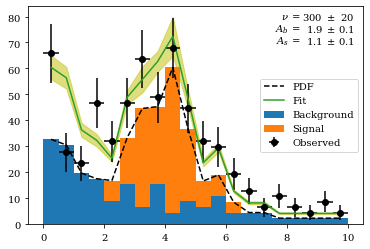

In [31]:
x   = (bins[1:]+bins[:-1])/2
plot     (x, pdf(x,1,1),       '--k',                    label='PDF')
plot_hist(*backg_h,            as_bar=True,ecolor='none',label='Background')
plot_hist(*signal_h,backg_h[0],as_bar=True,ecolor='none',label='Signal')
plot_hist(*data_h,             fmt='o',     color='k',   label='Observed')
plot_fit_func(x, pdf, p[1:], cov[1:,1:],    color='C2',  label='Fit')
plot_fit_table(p,cov,parameters=[r'\nu','A_{b}','A_{s}'])
legend(loc='center right');

## Systematic uncertainties (nuisance parameters)

Often a template has associated [_systematic uncertainties_](https://en.wikipedia.org/wiki/Observational_error).  Such uncertainties reflect imperfect knowledge of the parameters that govern the template.  Typically examples are:

- If the template is generated through simulation, there may be parameters of the model which are not entirely
  known.  The effect of that imperfect knowledge is then estimate by various means and assigned as a 
  systematic uncertainty. 
- If the template is generated from observations, we may have made insufficient or inadequate calibrations of our
  measuring apparatus.  Again, the possible variation of these calibrations are assessed and a systematic
  uncertainty is assign. 

Systematic uncertainties are inherently _not_ statistical (i.e., random) in nature.   In the parlance of Chapter 1 ([here](#Generally-about-statistical-observations))

- _Statistical uncertainty_ is reducible and by doing so, we improve the _precision_ of the measurement. 
- _Systematic uncertainty_ is _not_ reducible (but we may correct for them with sufficient knowledge), 
  and as such reflect the _inaccuracy_ of our measurements. 
  
Nevertheless, we will want to include the effect of systematic uncertainties into our fitting.   This means that we will to some extend treat the systematic uncertainties _as if_ they are statistical.  We will thus assume that systematic uncertainties can be modeled as random variables with some probability distribution or as [nuisance parameters](https://en.wikipedia.org/wiki/Nuisance_parameter) - i.e., parameters which are not of primary interest but is needed by the model to capture the observations. 

## Systematiske usikkerheder (irretations parametre)

Ofte har en skabelon tilknyttet [_systematiske usikkerheder_](https://en.wikipedia.org/wiki/Observational _fejl). Sådanne usikkerheder afspejler ufuldstændig viden om de parametre, der styrer skabelonen. Typiske eksempler er:

- Hvis skabelonen genereres fra en simulering kan der være parametre i modellen som ikke er 
  kendte. Effekten af den ufuldkomne viden estimeres derefter på forskellige måder og tildeles som en
  systematisk usikkerhed.
- Hvis skabelonen er genereret fra observationer har vi muligvis foretaget utilstrækkelige kalibreringer af vores
  måleudstyr. Igen vurderes den mulige variation af disse kalibreringer og en systematisk
  usikkerhed er tilordnet.

Systematiske usikkerheder er i sagens natur _ikke_ af statistiske (dvs. tilfældige) karakter. I parlance af kapitel 1 ([her](#Generelt-om-statistiske-observationer))

- _Statistisk usikkerhed_ kan reduceres, og derved forbedrer vi målingens _præcision_.
- _Systematisk usikkerhed_ er _ikke_ reducerbar (men vi korrigerer muligvis for dem med tilstrækkelig viden),
  og som sådan afspejler _unøjagtigheden_ i vores målinger.
  
Ikke desto mindre ønsker vi at inkludere effekten af systematiske usikkerheder i vores tilpasning. Det betyder at vi i nogen udstrækning vil behandle de systematiske usikkerheder _som om_ de er statistiske. Vi antager således, at systematiske usikkerheder kan modelleres som tilfældige variabler med en vis sandsynlighedsfordeling eller som [irretations parametre](https://da.wikipedia.org/wiki/Nuisance_parameter) - dvs. parametre, der ikke er af primær interesse, men er nødvendig af modellen kan indfange observationer.

### Overall (normalisation)

Consider a template which we believe to understand up to some overall scaling factor which we however have estimated bounds for.  That is, our template is believed to be scaled around unity, but could in principle be smaller or larger parameterised by $s$

$$g(x;\hat\theta) = (1+s) f(x;\hat\theta)\quad.$$ 

We can choose the overall scale of $f$ such that the nominal value (i.e., the value we believe the template has) corresponds to $s=0$.  Furthermore, we will consider $s$ as a _nuisance parameter_ - that is, it is in itself a random variable with some probability distribution $h(s)$ (which does, however not depend on $\hat\theta$).

The likelihood of the template is then given by 

### Samlet (normalisering)

Overvej en skabelon, som vi mener at forstå op til en overordnet skaleringsfaktor, som vi har estimeret grænser for. Det vil sige, at vores skabelon antages at være skaleret omkring én, men kan i princippet være mindre eller større parameteriseret ved $s$

$$g(x;\hat\theta) = (1+s) f(x;\hat\theta)\quad.$$

Vi kan vælge den samlede skala af $f$ således at den nominelle værdi (dvs. den værdi, vi mener, at skabelonen har) svarer til $s=0$. Desuden vil vi betragte $s$ som en _irretations parameter_ - det vil sige, det er i sig selv en tilfældig variabel med en vis sandsynlighedsfordeling $h(s)$ (hvilket dog ikke afhænger af $\hat\theta$).

Sandsynligheden for skabelonen gives derefter af

In [32]:
from sympy import symbols, log as sylog, exp as syexp, Product, Function, Eq, IndexedBase
thetahat,s = symbols('thetahat s',real=True)
x    = IndexedBase('x',real=True)
i,m  = symbols('i m',integer=True,positive=True)
f    = Function('f',real=True,positive=True)(x[i],thetahat)
g    = Function('g',real=True,positive=True)(x[i],thetahat)
h    = Function('h',real=True,positive=True)(s)
Lcal = Function('Lcal',real=True)(x,thetahat,s)
gg = (1 + s) * f 
L  = (Product(gg,(i,1,m))*h).simplify()
Eq(Lcal,Eq(Product(g,(i,1,m)),L),evaluate=False)

Eq(Lcal(x, thetahat, s), Eq(Product(g(x[i], thetahat), (i, 1, m)), (s + 1)**m*h(s)*Product(f(x[i], thetahat), (i, 1, m))))

The logarithm of this gives us the logarithmic likelihood 

Logaritmen heraf giver os den logaritmiske sandsynlighed

In [33]:
elln = Function('ell',real=True)(x,thetahat,s)
ell  = sylog(L).expand(log=True,force=True).simplify()
Eq(elln,ell)

Eq(ell(x, thetahat, s), m*log(s + 1) + log(h(s)) + Sum(log(f(x[i], thetahat)), (i, 1, m)))

Thus, we see that the addition of the nuisance parameter $s$ modifies the (logarithmic) likelihood by 

$$m\log(s+1) + \log(h(s))\quad,$$ 

where $h(s)$ is the probability density function (PDF) of $s$. 

To see what that means, let us assume that we have determined the mean and standard deviation of $s$ to be $0$ and $\delta_s$, respectively.   That means, we are $\approx 68\%$ confident that the template is given by the range 

$$(1+\delta_s) f(x;\hat\theta)\quad.$$ 

Let us further assume that $s$ is normal distributed $\mathcal{N}[0,\delta_s]$.  Then we find that 

Således ser vi, at tilføjelsen af irretations-parameteren $s$ ændrer den (logaritmiske) sandsynlighed med

$$m\log(s+1) + \log(h(s))\quad,$$

hvor $h(s)$ er sandsynlighedsfordelingen (PDF) af $s$.

For at se hvad det betyder så lad os antage at vi har bestemt gennemsnittet og standardafvigelsen for $s$ til henholdsvis $0$ og $\delta_s$. Det betyder, at vi er $\approx 68\%$ overbeviste om, at skabelonen er angivet af intervallet

$$(1+\delta_s) f(x;\hat\theta)\quad.$$

Lad os endvidere antage, at $s$ er normalfordelt $\mathcal{N}[0,\delta_s]$. Så finder vi

In [34]:
from sympy import pi as sypi, sqrt as sysqrt, S
deltas = symbols('delta_s',real=True,positive=True)
nell = ell.replace(h,1/(sysqrt(2*sypi)*deltas)*syexp(-S.Half*(s/deltas)**2))\
       .expand().simplify()
Eq(elln,nell)

Eq(ell(x, thetahat, s), m*log(s + 1) - log(delta_s) + Sum(log(f(x[i], thetahat)), (i, 1, m)) - log(pi)/2 - log(2)/2 - s**2/(2*delta_s**2))

Below we will implement a _decorator_ that adds a systematic uncertainty to a PDF via a nuisance parameter. We will, however, for the sake of generalisability, phrase is slightly differently from above.  We will parameterise $s$ as a function of a $\alpha$ such that varying $\alpha$ will vary $s$.  Thus our nuisance parameter becomes $\alpha$, and we need the probability density function of $\alpha$.  We do so to allow for _asymmetric_ uncertainties, and $s(\alpha)$ will interpolate between the given lower bound $\delta_-$, nominal value $\delta_0$, and upper bound $\delta_+$ so that 

Nedenfor implementerer vi en _dekoratør_, der tilføjer en systematisk usikkerhed til en PDF via en irretations parameter. Vi vil dog, af hensyn til generaliserbarhed, have et lidt anderledes udtryk end ovenover. Vi parameteriserer $s$ som en funktion af et $\alpha$, således at varierende $\alpha$ vil variere $s$. Vores irretations parameter blliver $\alpha$, og vi har brug for sandsynlighedsfordelingen af $\alpha$. Derved gør vi det muligt at angive _asymmetrisk_ usikkerhed, og $s(\alpha)$ vil interpolere mellem den givne nedre grænse $\delta_-$, nominel værdi $\delta_0$ og øvre grænse $\delta_+$, med

$$\begin{cases} 
  \delta_- & \alpha = -1\\
  \delta_0 & \alpha = 0\\
  \delta_+ & \alpha - +1
  \end{cases}\quad.$$

Note, $\alpha$ can be smaller than -1 and larger than +1 by means of extrapolation. However, $|\alpha|>1$ corresponds to the systematic uncertainty varied beyond one standard deviation in either direction, and should be unlikely. 

If the function being decorated evaluates 

Bemærk, $\alpha$ kan være mindre end -1 og større end +1 ved hjælp af ekstrapolering. Dog svarer $|\alpha|>1$  til en systematisk usikkerhed, der varierede ud over en standardafvigelse i begge retninger, og bør være usandsynlig.

Hvis den funktion, der er dekoreret, evaluere 

$$f(x;\hat\theta) = \ldots\quad,$$ 

then the _decorated function_, with relative uncertainties $\delta^-,\delta^0$, and $\delta^+$, becomes 

så bliver _dekoreret funktion_, med relative usikkerheder $\delta^-,\delta^0$ og $\delta^+$,

$$f_w(x;\alpha,\hat\theta) = \begin{pmatrix}
  \left[1+s(\alpha)\right]\cdot f(x;\hat\theta)\\
  h(\alpha)\quad
  \end{pmatrix},$$ 

where $s(\alpha)$ interpolates between $\delta^-$ and $\delta^+$ over $\delta^0$ according to the parameter $\alpha\in[-1,1]$, and $h$ is the probability density function of $\alpha$ (assumed normal if not given).  If a logarthmic PDF $g=\log f$ is given, as well as a logarithmic PDF for $\alpha$ $j = \log h$, then the decorated function evaluates 

hvor $s(\alpha)$ interpolerer mellem $\delta^-$ og $\delta^+$ over $\delta^0$ i henhold til parameteren $\alpha\in[-1,1]$, og $h$ er sandsynlighedsfordelingen for $\alpha$ (antages normalt, hvis ikke angivet). Hvis der gives en logarthmisk PDF-$g=\log f$, samt en logaritmisk PDF til $\alpha$ $j = \log h$, evaluerer den dekorerede funktion

$$g_w(x;\alpha,\hat\theta) = \begin{pmatrix}
  \log\left[1+s(\alpha)\right] + g(x;\hat\theta)\\
  j(\alpha)\quad
  \end{pmatrix} = 
  \begin{pmatrix} 
    \log\left[1+s(\alpha)\right]+\log f(x;\hat\theta)\\
    \log h(\alpha)\end{pmatrix}\quad,$$

where $j$ is assumed the logarithm of the normal distribution if not specified. 

hvor $j$ antages logaritmen til den normale fordeling, hvis ikke specificeret.

The added systematic uncertainty should be expressed as _relative_ and corresponding elements of `up` and `down` must have opposite signs. 

Two important notes:

- The decorator _adds an additional argument to the front of the argument list_ which is the $\alpha$ parameter. 
- The decorator _adds a return value to the end of the return list_ which is the probability of $\alpha$. This is why we allow for two return values in the implementation of `llh` and `binned_llh` in the previous chapter. 

When visualising, we can simply ignore the second return value. 

As for `histo_pdf` we can specify the kind of interpolation we want to perform by passing the `kind` keyword to the decorator. 

Den tilføjede systematiske usikkerhed skal udtrykkes som _relativ_ og tilsvarende elementer af `up` og `down` skal have modsatte tegn.

To vigtige bemærkninger:

- Dekoratøren _tilføjer et yderligere argument foran i argumentlisten_, som er $\alpha$-parameteren.
- Dekoratøren _tilføjer en returværdi til slutningen af returlisten_, hvilket er sandsynligheden for $\alpha$. Dette er grunden til, at vi giver mulighed for to returneringsværdier i implementeringen af `llh` og `binned _llh` i det forrige kapitel.

Når vi visualiserer, kan vi ignorere den anden returværdi.

Ligesom for `histo_pdf`, kan vi specificere typen interpolering, vi ønsker at udføre, ved at angive `type`-nøgleordet til dekoratøren.

In [47]:
def overall_sys_pdf(down,up,mid=None,kind='slinear',logpdf=False,extra=True,
                    alpha_pdf=None,**kwargs):
    from scipy.stats import norm
    from scipy.interpolate import interp1d 
    from numpy import sign, add, multiply, inf, identity, log
    from functools import wraps
    
    if alpha_pdf is None:
        alpha_pdf = norm(0,1).logpdf if logpdf else norm(0,1).pdf 

    assert sign(down) != sign(up), f'Down {down} and up {up} must have opposite sign'
    
    if mid is None:
        mid = (down+up)/2
    inter = interp1d([-1,0,1],[down,mid,up],
                     kind=kind,copy=True,bounds_error=False,assume_sorted=True,
                     fill_value='extrapolate' if extra else (-inf,-inf),**kwargs)
    
        
    op1 = add if logpdf else multiply
    op2 = log if logpdf else lambda x:x
    
    def wrap(f):
        @wraps(f)
        def wrapper(x,alpha,*args,**kwargs):
            return op1(op2(1+inter(alpha)), f(x,*args)), alpha_pdf(alpha)
        
        return wrapper
    
    return wrap

To see the effect on a PDF, we define add $\pm10\%$ systematic uncertainty on a normal distribution and plot for $\alpha=0,-1,+1$. 

For at se effekten på en PDF definerer vi systematisk usikkerhed $\pm10\%$ på en normal distribution og tegner for $\alpha=0,-1,+1$.

Overall scaling by systematic uncertainty. 

Overordnet skalering med systematisk usikkerhed.

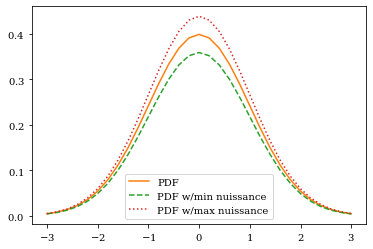

In [49]:
@overall_sys_pdf(-.1,.1,logpdf=False,extra=True)
def overall_pdf(x):
    from scipy.stats import norm
    return norm.pdf(x,0,1)

xev = linspace(-3,3,31)
plot(xev,overall_pdf(xev, 0)[0],label='PDF',                color='C1')
plot(xev,overall_pdf(xev,-1)[0],label='PDF w/min nuissance',color='C2',ls='--')
plot(xev,overall_pdf(xev, 1)[0],label='PDF w/max nuissance',color='C3',ls=':')
legend();

We can also plot the same distribution with $1$ and $2$ sigma contours 

Vi kan også tegne den samme distribution med $1$ og $2$ sigma konturer

Confidence contours from systematic uncertainties.

Tillidskonturer fra systematiske usikkerheder.

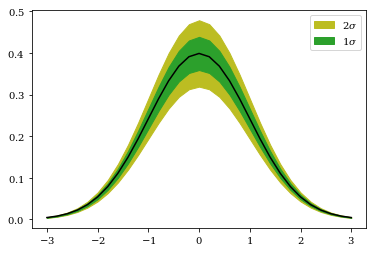

In [50]:
from matplotlib.pyplot import fill_between

fill_between(xev,
             overall_pdf(xev,-2)[0],
             overall_pdf(xev,+2)[0],
             color='C8',alpha=1,label=r'$2\sigma$')
fill_between(xev,
             overall_pdf(xev,-1)[0],
             overall_pdf(xev,+1)[0],
             color='C2',alpha=1,label=r'$1\sigma$')
plot(xev,overall_pdf(xev,0)[0],'-k')
legend();

### Example: Signal over background again

### Eksempel: Signal over baggrund igen

As an example, let us take our signal over background example from above.  We will, however, add a systematic uncertainty of $\pm10\%$ onto the background template. 

We must take care when defining the sum PDF, that we return the nuisance probability as the second return value. 

Lad os som et eksempel tage vores signal over baggrundseeksempel ovenfra. Vi vil dog tilføje en systematisk usikkerhed på $\pm10\%$ til baggrundsskabelonen.

Vi skal passe på, når vi definerer summen af PDF'erne, at vi returnerer irretations sandsynlighed som den anden returværdi.

In [51]:
@overall_sys_pdf(-.1,.1)
@scale_pdf()
def backg_f(x,h=histo_pdf(backg_h[1], backg_h[0], kind='nearest')):
    return h(x)

def pdf(x,backg_alpha,backg_a,signal_a):
    from scipy.stats import norm
    from numpy import multiply, log
    
    bg = backg_f (x,backg_alpha,backg_a)
    sg = signal_f(x,signal_a)
    
    return bg[0] + sg, bg[1]

Note how we can _compound_ decorators.  The function `backg_f` defined above is _both_ scaled _and_ have a nuisance parameter.   Let us do our EB-MLE fit again 

Bemærk, hvordan vi kan _sammensætte_ dekoratører. Funktionen `backg_f` defineret ovenfor er _både_ skaleret _og_ har en irretations parameter. Lad os lave vores EB-MLE tilpasning igen

In [52]:
p, cov = mle_fit(pdf,(bins,data_h[0]),(1,0,1,1),
                 extended=True,poisson=True,tol=1e-5)

For visualisation we define a function which only takes the first returned value (PDF evaluated) from our PDF. 

Til visualisering definerer vi en funktion, der kun returnerer den første returnerede værdi (PDF evalueret) fra vores PDF.

In [53]:
def viz_pdf(x,*args):
    return pdf(x,*args)[0]

Again, we plot our templates, data, fitted function, and fit contours. 

Igen tegner vi vores skabeloner, data, tilpasset funktion og tilpasningskonturer.

Fit with overall systematic uncertainty.  Result is shown on the left, and confidence contours to the right. 

Tilpasning af overordnede systematiske usikkerhed. Resultatet vises til venstre, og tillidskonturerne til højre.

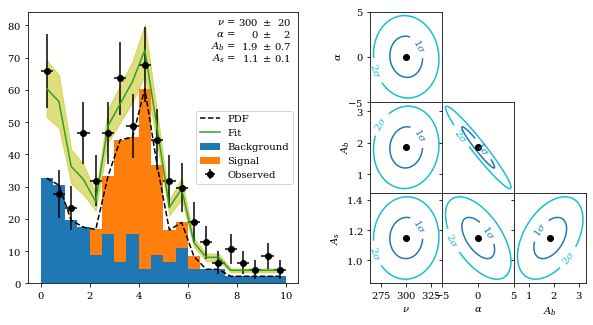

In [54]:
from matplotlib.pyplot import figure, sca, gca

x   = (bins[1:]+bins[:-1])/2

fig = figure(figsize=(10,5))
ax  = fig.subplots(ncols=1,nrows=1,gridspec_kw=dict(right=.5))

pn  = [r'\nu',r'\alpha','A_{b}','A_{s}']
plot     (x, viz_pdf(x,0,1,1), '--k',                    label='PDF')
plot_hist(*backg_h,            as_bar=True,ecolor='none',label='Background')
plot_hist(*signal_h,backg_h[0],as_bar=True,ecolor='none',label='Signal')
plot_hist(*data_h,             fmt='o',     color='k',   label='Observed')
plot_fit_func(x, viz_pdf, p[1:], cov[1:,1:],  color='C2',label='Fit')
plot_fit_table(p,cov,parameters=pn)
legend(loc='center right')

plot_nsigma_contour(p,cov,[1,2],parameters=pn,fig=fig,
                    gridspec_kw=dict(left=.6));

From the contour plot on the right, we see that $A_b$ and $\alpha$ are strongly anti-correlated, which is not too surprising as both $A_b$ and $\alpha$ will raise or lower the background template. 

Fra konturplottet til højre ser vi, at $A_b$ og $\alpha$ er stærkt antikorreleret, hvilket ikke er overraskende, da både $A_b$ og $\alpha$ vil hæve eller sænke baggrundsskabelonen.

### Shape ($x$-dependent) 

### Form ($x$-afhængig)

Above, our systematic uncertainty only changed the overall normalisation of a template.  However, we can also think of systematic uncertainties that will change the _shape_ of the template, or equivalently, depend on the independent variable $x$.  That is, we can have 

$$g(x;\hat\theta) = (1+s(x))\cdot f(x;\hat\theta)\quad.$$ 

In that case, we find 

Ovenfor ændrede vores systematiske usikkerhed kun den overordent normalisering af en skabelon. Vi kan dog også tænke på systematiske usikkerheder, der vil ændre _formen_ af skabelonen, eller ækvivalent, afhænge af den uafhængige variabel $x$. Vi kan have

$$g(x;\hat\theta) = (1+s(x))\cdot f(x;\hat\theta)\quad.$$

I det tilfælde finder vi

In [55]:
x     = IndexedBase('x',real=True)
alpha = symbols('alpha',real=True)
s     = Function('s',real=True)(x[i],alpha)
gg    = (1 + s) * f 
h     = Function('h')(alpha)
L     = (Product(gg,(i,1,m))*h).simplify()
Lcal  = Function('Lcal',real=True,positive=True)(x,thetahat,alpha)
Eq(Lcal,Eq(Product(g,(i,1,m)),L),evaluate=False)

Eq(Lcal(x, thetahat, alpha), Eq(Product(g(x[i], thetahat), (i, 1, m)), h(alpha)*Product((s(x[i], alpha) + 1)*f(x[i], thetahat), (i, 1, m))))

and the logarithmic likelihood 

og den logaritmiske sandsynlighed

In [56]:
ell  = sylog(L).expand(log=True,force=True).simplify()
elln = Function('ell',real=True)(x,thetahat,alpha)
Eq(elln,ell)

Eq(ell(x, thetahat, alpha), log(h(alpha)) + Sum(log(s(x[i], alpha) + 1) + log(f(x[i], thetahat)), (i, 1, m)))

where we again have parameterized $s$ in terms of $\alpha$.  Thus, our logarithmic likelihood is modified by the logarithm of the PDF of $\alpha$ - $\log h(\alpha)$.  We can therefore implement a decorator much as we did above, except the term $(1+s(x,\alpha))$ depends on the independent variable $x$.

hvor vi igen har parameteriseret $s$ med $\alpha$. Den logaritmiske sandsynlighed ændres med ved logaritmen til PDF'en for $\alpha$ - $\log h(\alpha)$. Vi kan derfor implementere en dekoratør, som vi gjorde ovenfor, bortset fra at udtrykket $(1+s(x,\alpha))$ afhænger af den uafhængige variabel $x$.

If the function being decorated evaluates 

Hvis den funktion, der er dekoreret, evaluerer

$$f(x;\hat\theta) = ...\quad,$$ 

then the _decorated function_, with relative uncertainties $\delta^-,\delta^0$, and $\delta^+$, becomes 

så evaluerer den _dekoreret_ funktion_, med relative usikkerheder $\delta^-,\delta^0$ og $\delta^+$,

$$f_w(x;\hat\theta) = \left[1+s(x,\alpha)\right]\cdot f(x;\hat\theta)\quad,$$ 

where $s(x,\alpha)$ interpolates between $\delta^-$ and $\delta^+$ over $\delta^0$ according to the parameter $\alpha\in[-1,1]$.  The interpolation will be dependent on $x$, and we must therefore pass `up`, `down`, and possibly `mid` as values that depend on $x$ (e.g., arrays).  

We can specify different kinds of interpolation (see `scipy.interpolate.interp2d`).  Some important notes on the decorated and the decorated function. 

- `up` and `down` must have opposite sign at each point. 
- The decorator _adds an additional argument to the begining of the argument list_. 
- The decorator _adds an additional return value_ to the decorated function. 


hvor $s(x,\alpha)$ interpolerer mellem $\delta^-$ og $\delta^+$ over $\delta^0$ i henhold til parameteren $\alpha\in[-1,1]$. Interpolationen vil være afhængig af $x$, og vi må derfor give `up`, `down` og muligvis `mid` som værdier, der afhænger af $x$ (f.eks. _arrays_).

Vi kan specificere forskellige former for interpolering (se `scipy.interpolate.interp2d`). Nogle vigtige noter om den dekoratøren og den dekoreret funktion.

- `up`' og `down` skal have modsat tegn i hvert punkt.
- Dekoratøren _tilføjer et yderligere argument til begyndelsen af argumentlisten_.
- Dekoratøren _tilføjer en ekstra returværdi_ til den dekoreret funktion.

Note, we may pass _callable_ for `down`, `up`, and optionally `mid`.  If `ev=None`, then we will interpolate between the three function evaluations when the wrapped function is called.  Otherwise, we will evaluate these function at `ev` and interpolate between those points (with a static interpolator).  If `up`, `down`, and optionally `mid` are scalars (0-dimension objects), then we simply forward to `overall_sys_pdf` above.  Finally, we can pass value arrays for `up`, `down`, possibly `mid`, and `ev` which we will then interpolate (in $x$ and $\alpha$) between (using a static object). 

Bemærk, vi kan muligvis sende _callable_ (funktion eller klasse metode) for `up`, `down` og eventuelt `mid`. Hvis `ev=None`, så interpolere vi mellem de tre funktioner evaluaret, når den indpakket funktion kaldes. Ellers vil vi evaluere disse funktioner på `ev` og interpolere mellem disse punkter (med en statisk interpolator). Hvis `down`, `ned` og eventuelt `mid` er skalarer (0-dimensionelle objekter), videresender vi til `overall_sys_pdf` ovenfor.  Endelig kan vi give lister af værdier for `up`, `down`, eventuelt `mid` og `ev`, som vi vil interpolerer (over $x$ og $\alpha$) mellem (med et statisk objekt). 

In [57]:
def shape_sys_pdf(down,up,mid=None,ev=None,kind='linear',logpdf=False,
                  extra=False,alpha_pdf=None,**kwargs):
    from scipy.interpolate import interp2d, interp1d 
    from scipy.stats import norm
    from numpy import vstack, sign, add, multiply, logical_and, logical_or, ndim, inf
    from functools import wraps

        
    op = add if logpdf else multiply
    if alpha_pdf is None:
        alpha_pdf = norm(0,1).logpdf if logpdf else norm(0,1).pdf 
    
    if callable(down) and callable(up) and (mid is None or callable(mid)):
        if mid is None:
            mid = lambda x : (up(x)+down(x))/2
            
        if ev is None:
            kw = kwargs.copy()
            
            def wrap(f):
                @wraps(f)
                def wrapper(x,alpha,*args,**kwargs):
                    z = vstack((down(x), mid(x), up(x))).T 
                    i = interp1d([-1,0,1],z,kind=kind,copy=True,bounds_error=False,
                                 assume_sorted=True,
                                 fill_value='extrapolate' if extra else (-inf,-inf),
                                 **kw)
                    return op.reduce((1+i(alpha), f(x,*args,**kwargs))), alpha_pdf(alpha) 
                
                return wrapper
            
            return wrap
            
        else:
            up,down,mid = up(ev), down(ev), mid(ev)

    if ndim(down) == 0 and ndim(up) == 0 and (mid is None or ndim(mid) == 0):
        return overall_sys_pdf(down,up,mid,kind=kind,logpdf=logpdf,
                               extra=extra,alpha_pdf=alpha_pdf,**kwargs)
    
    assert all(logical_or(sign(down) != sign(up), logical_and(down==0,up==0))), \
        f'Down {down} and up {up} must have opposite sign'
    
    if mid is None:
        mid = (down+up)/2
    z     = vstack((down,mid,up))
    inter = interp2d(ev,[-1,0,1],z,kind=kind,copy=True,bounds_error=False,
                     fill_value=None if extra else 0,**kwargs)
    
    def wrap(f):
        @wraps(f)
        def wrapper(x,alpha,*args,nopdf=False):
            return op.reduce((1+inter(x,alpha),f(x,*args,**kwargs))), alpha_pdf(alpha)
        
        return wrapper 
    
    return wrap 

### Test 

Let us do a small test of our decorator.  We will take a normal distribution and a systematic uncertainty that is linear in $x$.

Lad os lave en lille test af vores dekoratør. Vi tager en normal fordeling og en systematisk usikkerhed, der er lineær i $x$.

Modification by shape systematic uncertainty. 

Ændring efter form af systematisk usikkerhed.

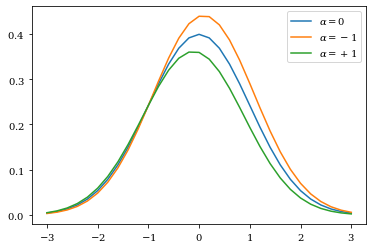

In [58]:
x = linspace(-3,3,31)
up = lambda x : 0.1 + 0.1 * x 
down = lambda x : -0.1 - 0.1 * x

@shape_sys_pdf(down,up)
def shape_pdf(x,*args):
    from scipy.stats import norm 
    
    return norm.pdf(x,*args)

plot(x, shape_pdf(x, 0)[0],label=r'$\alpha=0$')
plot(x, shape_pdf(x, 1)[0],label=r'$\alpha=-1$')
plot(x, shape_pdf(x,-1)[0],label=r'$\alpha=+1$')
legend();

Let us time the difference between 

- Evaluation of interpolation at runtime - i.e., when the wrapped function is called, and 
- pre-evaluated interpolations by passing arrays for `up`, `down`, and `ev`. 

Lad os tage tid på forskellen mellem

- Evaluering af interpolering ved kørsel - dvs. når den indpakket funktion kaldes, og
- forevaluerede interpolationer ved at give lister for `up`, `down` og `ev`.

In [59]:
ev    = linspace(-3,3,11)
aup   = up(ev)
adown = down(ev)

@shape_sys_pdf(down,up,ev=ev)
def ashape_pdf(x,*args):
    from scipy.stats import norm 
    
    return norm.pdf(x,*args)
  
%timeit shape_pdf(x,.5)
%timeit ashape_pdf(x,.5)

415 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
293 µs ± 712 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We see that the runtime evaluation is only marginally slower than the pre-evaluated interpolation.  We are thus free to pick which form is most suitable for us. 

Vi ser, at evaluering under kørsel kun er marginalt langsommere end den forevaluerede interpolation. Vi kan således vælge hvilken form der er bedst egnet til os.

### Example: Peak over backgrounds 

### Eksempel: Top over baggrunde

We will revisit our example above ([her](#Example:-Peak-over-background)), but this time we will add another background template to which we will add an $x$ dependent systematic uncertainty. 

Vi vil gå tilbage til vores eksempel ovenfor ([here](#Eksempel:-Top-over-baggrund)), men denne gang tilføjer vi endnu en baggrundskabelon, som vi vil tilføje en $x$-afhængig systematisk usikkerhed på.

First, we generate our new background template as uniform over $x$ and with an increasing systematic uncertainty.  

Først genererer vi vores nye baggrundsskabelon som ensartet over $x$ og med en stigende systematisk usikkerhed. 

In [60]:
from numpy.random import uniform
from numpy import arange, zeros_like

backg2_x = uniform(0,10,size=100)
backg2_h = histogram(backg2_x, bins)
up       =  arange(0.01, 0.11, 0.005)
down     = -arange(0.005,0.055,0.0025)
mid      = zeros_like(up)
x        = (bins[1:]+bins[:-1])/2

@shape_sys_pdf(down,up,mid,ev=x)
@scale_pdf()
def backg2_f(x,h=histo_pdf(backg2_h[1],backg2_h[0])):
    return h(x)

Then, we draw the PDFs of the signal, and old and new backgrounds. 

Derefter tegner vi PDF'erne til signalet og gamle og nye baggrunde.

Templates. 

Skabeloner.

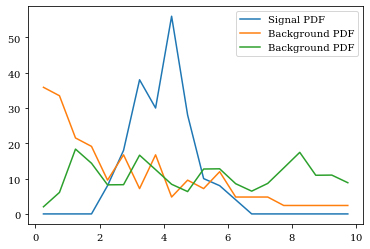

In [61]:
plot(x, signal_f(x,1),     label='Signal PDF')
plot(x, backg_f (x,1,1)[0],label='Background PDF')
plot(x, backg2_f(x,1,1)[0],label='Background PDF')
legend();

We generate a new data sample with the uniform background added in. We do, however modify it in an $x$ dependent way with $+2\%$ so that we may reconstruct that in the fit. 

Vi genererer en ny dataprøve med den ensartede baggrund tilføjet. Vi ændrer den dog på en $x$-afhængig måde med $+3\%$, så vi kan rekonstruere det i tilpasningen.

In [62]:
data_x    = concatenate((data_x,1.03*uniform(0,10,size=50)))
data_h    = histogram(data_x,bins)

Let us draw the three templates and our data. 

Lad os tegne de tre skabeloner og vores data.

Templates and data. 

Skabeloner og data.

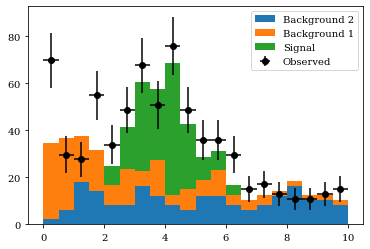

In [63]:
plot_hist(*backg2_h,                        as_bar=True,ecolor='none',label='Background 2')
plot_hist(*backg_h, backg2_h[0],            as_bar=True,ecolor='none',label='Background 1')
plot_hist(*signal_h,backg2_h[0]+backg_h[0], as_bar=True,ecolor='none',label='Signal')
plot_hist(*data_h,                          fmt='o',     color='k',   label='Observed')
legend();

The PDF to fit is given by the three template PDFs $f_{B_1}$, $f_{B_2}$, and $f_S$.   We define the total PDF, which must return 

$$\begin{pmatrix} 
  f_{B_1}(x;\alpha_1,A_{B_1}) + f_{B_2}(x;\alpha_2,A_{B_2}) + f_{S}(x;A_{S})\\
  h_1(\alpha_1) h_2(\alpha_2)\end{pmatrix}\quad,
$$

where $h_1$ and $h_2$ are the PDFs of the nuisance parameters $\alpha_1$ and $\alpha_2$, and $A_{\cdot}$ are the individual scale parameters on the templates. 

In [64]:
def pdf(x,alpha1,bg1,alpha2,bg2,sg1):
    b1 = backg_f (x,alpha1,bg1)
    b2 = backg2_f(x,alpha2,bg2)
    s  = signal_f(x,sg1)
    
    return b1[0]+b2[0]+s, b1[1]*b2[1]

We are ready to do our template MLE fit.   Note, we pass initial values for 6 parameters 

- $\nu$: The overall normalisation (we expect $\approx 350$)
- $\alpha_1$: Nuissance parameter on first background ($\approx 0$)
- $A_{B_1}$: Scale of first background ($\approx 2$)
- $\alpha_2$: Nuissance parameter on second background ($\approx 0$)
- $A_{B_2}$: Scale of second background ($\approx 0.5$)
- $A_{S}$: Scale of signal ($\approx 1$)

Vi er klar til at lave vores MLE skabelon tilpasning. Bemærk, vi videregiver startværdier for 6 parametre

- $\nu$: Den samlede normalisering (vi forventer $\approx 350$)
- $\alpha_1$: Nuissance-parameter på første baggrund ($\approx 0$)
- $A_{B_1}$: Skala af første baggrund ($\approx 2$)
- $\alpha_2$: Nuissance-parameter på anden baggrund ($\approx 0$)
- $A_{B_2}$: Skala af anden baggrund ($\approx 0.5$)
- $A_{S}$: Skala af signal ($\approx 1$)

In [65]:
p, cov = mle_fit(pdf,(bins,data_h[0]),(1,0,1,0,1,1),
                 extended=True,poisson=True,tol=1e-5)

We draw the templates, the data, and our fitted PDF, as well as contour plots of the parameters. 

Vi tegner skabeloner, data og vores tilpasset PDF samt konturdiagrammer af parametrene.

Templates, data, and fit.  Result is shown on the left, with confidence contours on the right. 

Skabeloner, data og tilpasning. Resultatet vises til venstre med tillidskonturer til højre.

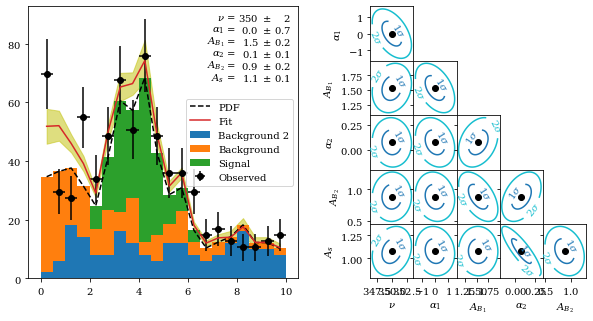

In [66]:
def viz_pdf(x,al1,ab1,al2,ab2,a):
    return pdf(x,al1,ab1,al2,ab2,a)[0]

fig = figure(figsize=(10,5))
ax  = fig.subplots(ncols=1,nrows=1,gridspec_kw=dict(right=.5))

pn  = [r'\nu',r'\alpha_1','A_{B_1}',r'\alpha_2','A_{B_2}','A_{s}']
ho  = dict(as_bar=True,ecolor='none')

plot     (x, viz_pdf(x,0,1,0,1,1), '--k',        label='PDF')
plot_hist(*backg2_h,                        **ho,label='Background 2')
plot_hist(*backg_h, backg2_h[0],            **ho,label='Background')
plot_hist(*signal_h,backg_h[0]+backg2_h[0], **ho,label='Signal')
plot_hist(*data_h,     fmt='o',     color='k',   label='Observed')
plot_fit_func(x, viz_pdf, p[1:], cov[1:,1:],color='C3',label='Fit')
plot_fit_table(p,cov,parameters=pn)
legend(loc='center right')

plot_nsigma_contour(p,cov,[1,2],parameters=pn,fig=fig,
                    gridspec_kw=dict(left=.6));


## Important remarks on systematic uncertainties 

## Vigtige bemærkninger til systematiske usikkerheder

Before leaving the systematic uncertainties, we will give a few very important remarks about the uncertainties we have modeled with `overall_sys_pdf` and `shape_sys_pdf` above.  These are in now way to be taken lightly: Understanding the underlying assumption makes all the difference between sound and meaningless (at best) results, or scientific dishonesty at worst. 

Inden vi forlader de systematiske usikkerheder, vil vi give et par meget vigtige bemærkninger om usikkerhederne, vi har modelleret med `overall_sys_pdf` og `shape_sys_ pdf` ovenfor. Disse skal på ingenmåde tages let: At forstå den underliggende antagelse gør forskellen mellem sund og meningsløse (i bedste fald) resultater eller videnskabelig uærlighed i værste fald.

First of all, it is important to realise that the systematic uncertainties modeled by _both_ `overall_sys_pdf` and `shape_sys_pdf` are _correlated_ over the independent variable $x$.  That is, changing our result within the systematic uncertainty for some $x=x_0$ implies changing the result for all $x\in D$ where $D$ is our independent variable range (the problem domain).  For `overall_sys_pdf` that is not surprising, but it may take a little consideration to see that this is also the case for `shape_sys_pdf`.   Remember, we have parameterized the uncertainty via the nuisance parameter $\alpha$. Changing $\alpha$ effects $s(x,\alpha$) for _all_ x.

For det første er det vigtigt at indse, at de systematiske usikkerheder, der er modelleret af _både_ `overall_sys_pdf` og `shape_sys_pdf`, er _korreleret_ over den uafhængige variabel $x$. Det vil sige, at ændring af vores resultat, indenfor den systematiske usikkerhed, for $x=x_0$ indebærer ændring af resultatet for alle $x\in D$, hvor $D$ er vores uafhængige variabelområde (problemdomænet). For `overall_sys_pdf` er det ikke overraskende, men det kan tage lidt overvejelse at se, at dette også er tilfældet for `shape_sys_pdf`. Husk, at vi har parametriseret usikkerheden via irretations-parametren $\alpha$. Ændring af $\alpha$ påvirker $s(x,\alpha$) for _alle_ x.

The second point to consider is the probability density function $h$ of the nuisance parameter $\alpha$.  If nothing else is specified, we assume that probability distribution to be normal.  This assumption is valid if the effect of the systematic uncertainty is expected to be normal distributed and our uncertainties are given as one (relative) standard deviation away from the expectation.   This is generally a perfectly acceptable assumptions as we will often assess systematic uncertainties as exactly the _variance_ of our template.  Such an estimate is typically called a _standard deviation_ (or _variance_) estimate of the systematic uncertainty. 

However, another common way of assessing a systematic uncertainty is to determine an envelope around the expectation.  For example, we could have that a given template is determined through simulations of some process.  We then vary the simulation (either by using a different model, or by changing the parameters of the simulation).  The envelope is then the _maximum deviation_ that we observe in the template.  We call such an estimate of a systematic uncertainty for _maximum deviation_ (or _range_) estimate of the systematic uncertainty. 

The two different estimates: _standard deviation_ and _maximum deviation_ are _not_ the same.  To see this, let us consider an example.  To keep things simple, we will consider a single value $y$ with a _true_ variance of unity and normal distributed around 0.  We can plot the half-maximum deviation ($\max(|y-\overline{y}|)/2$) versus the number of samples $n$ (we will do $m$ trials at each sample size) as a _candle stick_ chart. 

Det andet punkt, der skal overvejes, er sandsynlighedsfordelingen $h$ for irretations-parameteren $\alpha$. Hvis der ikke er angivet andet, antager vi, at sandsynlighedsfordelingen er normal. Denne antagelse er gyldig, hvis effekten af den systematiske usikkerhed forventes at være normalfordelt og vores usikkerheder er givet som en (relativ) standardafvigelse væk fra forventningen. Dette er generelt en rimelig antagelse, da vi ofte anslår til systematiske usikkerheder som nøjagtigt _variansen_ i vores skabelon. Et sådant estimat kaldes typisk et _standardafvigelse_ (eller _varians_) estimat af den systematiske usikkerhed.

En anden almindelig måde at anslå en systematisk usikkerhed er at bestemme en rand omkring forventningen. For eksempel kunne vi have, at en given skabelon bestemmes gennem simuleringer af en eller anden proces. Derefter varierer vi simuleringen (enten ved hjælp af en anden model eller ved at ændre parametre for simuleringen). Randen er derefter den _maksimale afvigelse_, som vi ser i skabelonen. Vi kalder et sådant skøn af en systematisk usikkerhed for _maksimal afvigelse_ (eller _rækkevidde_) estimering af den systematiske usikkerhed.

De to forskellige estimater: _standardafvigelse_ og _maksimal variation_ er _ikke_ de samme. Lad os overveje et eksempel for at se dette. For at holde tingene enkle, vil vi overveje en enkelt værdi $y$ med en _ægte_ varians på én og normal fordelt omkring 0. Vi kan plotte den halve maksimale afvigelse ($\max(|y-\overline{y}|)/2$) versus antallet af prøver $n$ (vi foretager $m$ forsøg ved hver prøvestørrelse) som et _candle stick_ diagram.

Half-range of data compared versus sample size. 

Halvinterval af data sammenlignet med prøvestørrelse.

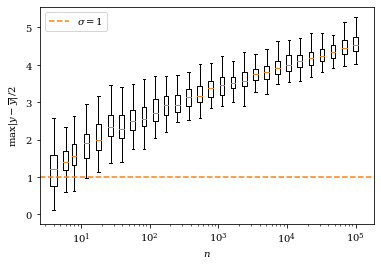

In [67]:
from numpy import geomspace,array,sqrt,abs,diff
from matplotlib.pyplot import xscale, xlabel, ylabel, axhline, boxplot

def samp(nn):
    y =  normal(size=nn)
    y -= y.mean()
    y =  abs(y)
    return y.max()

n    = geomspace(2,100000,30).astype(int)
m    = 100
mx   = array([[samp(nn) for _ in range(m)] for nn in n])
boxplot(mx.T,positions=n,sym='',widths=concatenate(([.5],diff(n)/2)))
axhline(1,label=r'$\sigma=1$',ls='--',color='C1')
xscale('log')
xlabel('$n$')
ylabel(r'$\max|y-\overline{y}|/2$')
legend();

We see that the maximum deviation is highly dependent on the sample size $n$, and is an good estimate of the standard deviation for very small samples and even then it is rather poor. 

Vi ser, at den maksimale afvigelse er meget afhængig af prøvestørrelsen $n$, og er et godt estimat af standardafvigelsen for meget små prøver, og selv da er den temmelig dårlig.

Another option is to use the _range_ (`ndarray.ptp` in _NumPy_) of the sample 

$$ R = \max y - \min y\quad,$$ 

to estimate the standard deviation.   

En anden mulighed er at bruge _rækkeviden_ (`ndarray.ptp` i _NumPy_) af prøven

$$ R = \max y - \min y\quad,$$

at estimere standardafvigelsen.

Range of data as a function of sample size. 

Dataområde som funktion af prøvestørrelse.

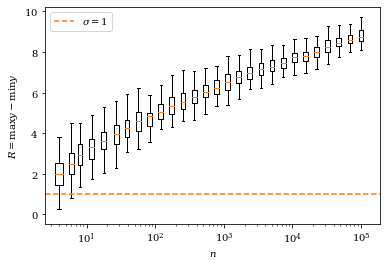

In [68]:
r   = array([[normal(size=nn).ptp() for _ in range(m)] for nn in n])
boxplot(r.T,positions=n,sym='',widths=concatenate(([.5],diff(n)/2)))
axhline(1,label=r'$\sigma=1$',ls='--',color='C1')
xscale('log')
xlabel('$n$')
ylabel(r'$R = \max y-\min y$')
legend();

which does not provide a much better estimate of the standard deviation.  

hvilket ikke giver et meget bedre estimat af standardafvigelsen.

In general, for a random variable $x$ with probability density function $f$ and cumulative density function $F$, we have that the [range](https://en.wikipedia.org/wiki/Range_(statistics)) has the cumulative distribution function 

Generelt for en tilfældig variabel $x$ med sandsynlighedstæthedsfunktion $f$ og kumulativ densitetsfunktion $F$, har vi, at [rækkeviden](https://en.wikipedia.org/wiki/Range_(statistik)) har den kumulative fordelingsfunktion

$$G(R) = N\int_{D}\mathrm{d}x\, f(x)\left[F(x+R)-F(x)\right]^{N-1}\quad,$$

where $N$ is the sample size and $D$ is the domain of the PDF and CDF. In practise this is almost impossible to evaluate.   The paper [Improving on the Range Rule of Thumb](https://scholar.rose-hulman.edu/rhumj/vol13/iss2/1/) provides a number of suggestions for how to go from the range of sample to the standard deviation for the normal, exponential, and uniform distributions 

hvor $N$ er prøvestørrelsen og $D$ er domænet for PDF og CDF. I praksis er dette næsten umuligt at evaluere. Papiret [Improving on the Range Rule of Thumb](https://scholar.rose-hulman.edu/rhumj/vol13/iss2/1/) indeholder et antal forslag til, hvordan man går fra prøven til standard afvigelse for en normal, eksponentiel og uniform fordeling

\begin{align*}
  \sigma\approx\begin{cases}
    \frac{R}{3\left(\sqrt{\log N} - \tfrac12\right)} & \mathcal{N}\\
    \frac{R}{\log N + \tfrac49}                      & \mathcal{E}\\
    \frac{R}{\sqrt{12}}\frac{N+1}{N-1}               & \mathcal{U}\\
  \end{cases}\quad,
\end{align*}

where $R=\max y - \min y$ is the observed range, and $N$ is the sample size.  

hvor $R=\max y - \min y$ er det observerede interval, og $N$ er prøvestørrelsen.

In the definition of `overall_sys_pdf` and `shape_sys_pdf`, we allow the user to pass an explicit (logarithmic) probability distribution for the nuisance parameter $\alpha$.  In the case of _maximum deviation_ type systematic uncertainties, it may be tempting to pass the uniform PDF 

$$h(\alpha) = \frac{1}{2}\begin{cases} 1 & |x| \leq 1\\ 0 & |x| > 1\end{cases}.$$ 

However, as is clear from the above, unless we have a great many number of samples, it is not reasonable to assume that we have indeed sampled the whole range.  A more conservative ansatz for small $N$ is to assume we have sampled _half_ the interval, and our PDF should be 

$$h(\alpha) = \frac{1}{4}\begin{cases} 1 & |x| \leq 2\\ 0 & |x| > 2\end{cases}.$$ 

I definitionen af `overall_sys_pdf` og `shape_sys_pdf` vi tillader brugeren at give en eksplicit (logaritmisk) sandsynlighedsfordeling for irretations-parametren $\alpha$. I tilfælde af _maksimal afvigelse_ type systematiske usikkerheder, kan det være fristende at give den uniforme fordeling

$$h(\alpha) = \frac{1}{2}\begin{cases} 1 & |x| \leq 1\\ 0 & |x| > 1\end{cases}.$$

Som det fremgår af ovenover, medmindre vi har et stort antal prøver, er det imidlertid ikke rimeligt at antage, at vi faktisk har taget stikprøver i hele området. En mere konservativt ansatz for lille $N$ er at antage, at vi har taget stikprøver fra _halvdelen_ intervallet, og vores PDF bør da være

$$h(\alpha) = \frac{1}{4}\begin{cases} 1 & |x| \leq 2\\ 0 & |x| > 2\end{cases}.$$

En sidste overvejelse omkring systematiske fejl.  Hvis to skabeloner _deler_ en systematisk fejl, så bør vi være påpasselige med at vi ikke bruger PDF'en af irretations-parametren $\alpha$ mere end én gang.   Den næmeste måde at sikre det på er ved at definerer en samlet PDF for de to skabeloner og så dekorerer den PDF med `overall_sys_pdf` eller `shape_sys_pdf`.  

For eksempel 

A final consideration concerning systematic uncertainties.  If two templates _share_ a systematic uncertainty, we must be careful not to evaluate the nuisance parameter $\alpha$ probability more than once.  The easiest way to do this, is to define a combined PDF for the to templates and then decorate that PDF with either `overall_sys_pdf` or `shape_sys_pdf`.  

For example 

In [69]:
@scale_pdf()
def bg1(x,h=backg_f):
    return h(x)

@scale_pdf()
def bg2(x,h=backg2_f):
    return h(x)

with the collected background PDF with an overall systematic uncertainty 

med den samlede baggrunds PDF med en overordnet systematisk usikkerhed

In [70]:
@overall_sys_pdf(down=-0.05, up=0.03)
def bg(x,a1,a2):
    return bg1(x,a1) + bg2(x,a2)


In general, if parts of our template PDFs shares parameters we must take care to write our final PDF to take that into account. 

Generelt, hvis dele af vores skabelon PDF'er deler parametre, skal vi sørge for at skrive vores endelige PDF så at det tages i betragtning.

## Summary

## Opsummering

We have seen how we can use binned maximum likelihood estimates to perform templating fitting. We have developed the function `histo_pdf` to make a histogram into a probability density function we can use in such (and other) fits.  We have developed the _decorators_ `scale_pdf` to insert a scale parameter on a PDF, and `overall_sys_pdf` and `shape_sys_pdf` to introduce _nuisance_ parameters to model systematic uncertainties. 

We have _not_ developed a large systematic framework for template fitting (such as for example [HistFactory](https://cds.cern.ch/record/1456844/) in [ROOT](https://root.cern.ch)) - rather we have opted for a simpler implementation in which choices are made transparent and up-front.  We have used the power of Python to express complex PDFs in a rather straight forward manner, leaving all the hard decisions to the user.  This is by _design_: The user _must_ be aware of the choices made to ensure proper analysis rather than relying on black-box implementations to always make the right choice for them.  

 i har set, hvordan vi kan bruge maksimale sandsynlighedsestimater til at udføre skabelon tilpasning. Vi har udviklet funktionen `histo_pdf` til at gøre et histogram til en sandsynlighedsfordeling, vi kan bruge i sådanne (og andre) tilpasninger. Vi har udviklet _dekoratører_ `scala_pdf` til at indsætte en skalaparameter i en PDF, og `overall_sys_pdf` og `shape_sys_pdf ` til at introducere _irretationsparametre_ til at modellere systematiske usikkerheder.

Vi har _ikke_ udviklet en stor systematisk ramme for skabelontilpasning (som f.eks. [HistFactory](https://cds.cern.ch/record/1456844/) i [ROOT](https://root.cern.ch)) - vi har snarere valgt en enklere implementering, hvor valg foretages gennemsigtigt og tydeligt. Vi har brugt Pythons kraft til at udtrykke komplekse PDF'er på en ligetil måde og overlade alle de hårde beslutninger til brugeren. Dette er et _designvalg_: Brugeren _skal_ være opmærksom på de valg, der er gjort for at sikre korrekt analyse snarere end at stole på en sort-boks implementering altid træffer det rigtige valg for dem.

In [71]:
histo_pdf.__doc__ = \
    """Generate a PDF function from a histogram 
    
    Parameters
    ----------
    x : array-like 
        Bin centres of the histogram (assume sorted)
    y : array-like 
        Bin content of the histogram 
    kind : str 
        The kind of interpolation to use.  
        See also `scipy.interpolate.interp1d` 
        
        'linear'    : Linear interpolation 
        'nearest'   : Value at nearest point 
        'zero'      : Zero-order spline  
        'slinear'   : Linear spline 
        'quadratic' : Quadratic spline 
        'cubic'     : Cubic spline 
        'previous'  : Value before 
        'next'      : Value after
    
    extra : bool
        If true, extrapolate according to `kind` beyond range
        of `x` 
        
    Returns
    -------
    f : callable 
        Function representing an unnormalized PDF of the histogram
    """

In [72]:
scale_pdf.__doc__ = \
    """Decorate to add norm to a PDF (any PDF)
    
    Parameters
    ----------
    logpdf : bool
        If true, assume decorated function returns logarithm of 
        the PDF 
        
    Returns
    -------
    wrapper : callable 
        A decorator that has norm fixed to n 
    """

In [73]:
overall_sys_pdf.__doc__ = \
    """A decorate that adds an overall systematic uncertainty to a PDF
    
    The uncertainties are assumed to be given as relative uncertainties.
    Down and up should have opposite signs 
    
    If several PDFs share the same systematic uncertainty, one best first 
    define a sum PDF and decorate that function 
    
        def pdf1(x,a):
            return 
            
        def pdf2(x,b):
            return
            
        @shape_sys_pdf(...)
        def pdf12(x,a,b):
            return pdf1(x,a)+pdf2(x,b)

    Parameters
    ----------
    down : scalar
        Downward uncertainty 
    up : scalar
        Upward uncertainty 
    mid : scalar (optional)
        If given, the central value of the uncertainty 
    kind : str  
        Interpolation kind (see scipy.interpolate.interp1d)
    logpdf : bool
        If true, assume decorated function returns logarithm of 
        the PDF 
    alpha_pdf : callable (optional)
        The (logarithm of) PDF of the nuissance parameter alpha.  If not given 
        assume it is normal distributed (mean of zero, standard deviation of 1). 
        If the nuissance parameter is not normal distributed (e.g., it is a 
        "maximum deviation" parameter) then one must supply an appropriate PDF here. 
        
        For example, if the nuissance parameter is "maximum deviation", then an 
        appropriate PDF would be a uniform distribution.  
        
            scipy.stats.uniform(-1,1).pdf
            
        Note, however, that this assumes the up and down boundaries are absolute, 
        which may not be reasonable (in evaluating the maximum deviation, we may
        not have sampled the entire parameter space).  A more reasonable ansatz is 
        to assume that we have sampled half the parameter space, so that our 
        nuissance parameter limits reflect half of the possible range. In that case
        the appropriate PDF would be 
        
            scipy.stats.uniform(-2,2).pdf
            
        which has a standard deviation of 2*sqrt(3)/3 = 1.15... .  Note, if one wants 
        to convert a maximum deviation uncertainty to a normal one standard deviation 
        uncertainty, one simply divides the maximum by sqrt(3).
        
        Note, if `logpdf=True`, then one must pass the logarithm of the PDF of alpha. 
        For example, 
        
            scipy.stats.uniform(-2,2).logpdf 
        
        In any case, the callable must have the exact form 
        
            def alpha_pdf(alpha):
                return ... 

    Returns
    -------
    wrap : callable 
        A decorator that adds a systematic uncertainty (nuissance) parameter 
    """

In [74]:
shape_sys_pdf.__doc__ = \
    """A decorate that adds a shape systematic uncertainty to a PDF
    
    The uncertainties are assumed to be given as relative uncertainties.
    Down and up should have opposite signs 
    
    If several PDFs share the same systematic uncertainty, one best first 
    define a sum PDF and decorate that function 
    
        def pdf1(x,a):
            return 
            
        def pdf2(x,b):
            return
            
        @shape_sys_pdf(...)
        def pdf12(x,a,b):
            return pdf1(x,a)+pdf2(x,b)
    
    Parameters
    ----------
    down : array-like, scalar, or callable
        Downward uncertainty 
    up : array-like, scalar, or callable
        Upward uncertainty 
    mid : array-like, scalar, or callable (optional)
        If given, the central value of the uncertainty 
    ev : array-like (optional) 
        Where the uncertainties are given in case 
        `up`, `down`, and possibly `mid` need to be evaluated 
        or are evaluated. 
    kind : str  
        Interpolation kind (see scipy.interpolate.interp1d)
    logpdf : bool
        If true, assume decorated function returns logarithm of 
        the PDF 
    alpha_pdf : callable (optional)
        The (logarithm of) PDF of the nuissance parameter alpha.  If not given 
        assume it is normal distributed (mean of zero, standard deviation of 1). 
        If the nuissance parameter is not normal distributed (e.g., it is a 
        "maximum deviation" parameter) then one must supply an appropriate PDF here. 
        
        For example, if the nuissance parameter is "maximum deviation", then an 
        appropriate PDF would be a uniform distribution.  
        
            scipy.stats.uniform(-1,1).pdf
            
        Note, however, that this assumes the up and down boundaries are absolute, 
        which may not be reasonable (in evaluating the maximum deviation, we may
        not have sampled the entire parameter space).  A more reasonable ansatz is 
        to assume that we have sampled half the parameter space, so that our 
        nuissance parameter limits reflect half of the possible range. In that case
        the appropriate PDF would be 
        
            scipy.stats.uniform(-2,2).pdf
            
        which has a standard deviation of 2*sqrt(3)/3 = 1.15... .  Note, if one wants 
        to convert a maximum deviation uncertainty to a normal one standard deviation 
        uncertainty, one simply divides the maximum by sqrt(3).
        
        Note, if `logpdf=True`, then one must pass the logarithm of the PDF of alpha. 
        For example, 
        
            scipy.stats.uniform(-2,2).logpdf 
            
        In any case, the callable must have the exact form 
        
            def alpha_pdf(alpha):
                return ... 
                

    Returns
    -------
    wrap : callable 
        A decorator that adds a systematic uncertainty (nuissance) parameter 
    """